In [2]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [3]:
import numpy as np

np.random.seed(2022)

In [4]:
# Windows で music21 を使うための余分なコード
import os
from music21 import environment

if os.name == 'nt':
    us = environment.UserSettings()
    us['musescoreDirectPNGPath']='C:/Program Files/MuseScore 3/bin/MuseScore3.exe'
    us['musicxmlPath']='C:/Program Files/MuseScore 3/bin/MuseScore3.exe'

In [5]:
data_dir = 'D:\\data\\gdl_book14\\MIDI\\jsbach'

In [6]:
if os.name == 'nt':
    LS_CMD = 'dir /s'
else:
    LS_CMD = 'ls -lR'
    
!{LS_CMD} {data_dir}

 ドライブ D のボリューム ラベルがありません。
 ボリューム シリアル番号は 606C-349E です

 D:\data\gdl_book14\MIDI\jsbach のディレクトリ

2021/12/11  10:53    <DIR>          .
2021/12/11  10:53    <DIR>          ..
2021/12/11  10:53    <DIR>          bwv1007
2021/12/11  10:53    <DIR>          bwv1008
2021/12/11  10:53    <DIR>          bwv1009
2021/12/11  10:53    <DIR>          bwv1010
2021/12/11  10:53    <DIR>          bwv1011
2021/12/11  10:53    <DIR>          bwv1012
               0 個のファイル                   0 バイト

 D:\data\gdl_book14\MIDI\jsbach\bwv1007 のディレクトリ

2021/12/11  10:53    <DIR>          .
2021/12/11  10:53    <DIR>          ..
1997/02/22  21:59             4,922 cs1-1pre.mid
1997/02/22  21:59             7,088 cs1-2all.mid
1997/02/22  22:00             6,159 cs1-3cou.mid
1997/02/22  22:25             3,209 cs1-4sar.mid
1997/02/22  23:13             5,704 cs1-5men.mid
1997/02/22  22:01             3,966 cs1-6gig.mid
               6 個のファイル              31,048 バイト

 D:\data\gdl_book14\MIDI\jsbach\bwv1008 のディレク

In [7]:
import os
import glob

midi_paths = glob.glob(os.path.join(data_dir, '*/*.mid'))

In [8]:
print(midi_paths[:2])

['D:\\data\\gdl_book14\\MIDI\\jsbach\\bwv1007\\cs1-1pre.mid', 'D:\\data\\gdl_book14\\MIDI\\jsbach\\bwv1007\\cs1-2all.mid']


In [9]:
data_filepath = 'run/music_params.pkl'

In [17]:
if os.name == 'nt':
    CAT_CMD = 'type'
else:
    CAT_CMD = 'cat'
    
! {CAT_CMD} {os.path.join('nw', 'LSTMMusic.py')}

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os
import glob
import pickle as pkl
import datetime

import music21
import itertools

###################################################################################
# DataLoader
###################################################################################
class ScoreDataset(tf.keras.utils.Sequence):
    def __init__(self, save_path='music_param.pkl', midi_paths=None, seq_len=32):
        if not midi_paths is None:
            self._build(midi_paths, seq_len)
            self.save(save_path)
        else:
            self.load(save_path)

        
    def _build(self, midi_paths, seq_len=32):
        self.seq_len = seq_len
        
        self.notes_list, self.durations_list = ScoreDataset.makeMusicData(midi_paths)

        notes_set = sorted(set(itertools.chain.from_iterable(self.notes_list))) # flatten 2D -> 1D, Unique, Sort
        durations_set = sorted(set(itertools.chain.from_iterable(se

In [9]:
import sys
sys.path.append('./nw')

from LSTMMusic import ScoreDataset

if not os.path.exists(data_filepath):
    data_seq = ScoreDataset(save_path=data_filepath, midi_paths=midi_paths, seq_len=32)
else:
    data_seq = ScoreDataset(save_path=data_filepath)

In [10]:
import sys
sys.path.append('./nw')

from LSTMMusic import LSTMMusic

lstm_music = LSTMMusic(
    data_seq.c_notes,
    data_seq.c_durations
)

In [11]:
# split data into train and val data.
import numpy as np

val_split = 0.05

N_DATA = len(data_seq)
N_VAL = int(N_DATA * val_split)

arr = np.arange(N_DATA)
np.random.shuffle(arr)

train_indices = sorted(arr[:-N_VAL])
val_indices = sorted(arr[-N_VAL:])

(train_x_notes, train_x_durations), (train_y_notes, train_y_durations) = data_seq[train_indices]
(val_x_notes, val_x_durations), (val_y_notes, val_y_durations) = data_seq[val_indices]

print(len(train_indices), len(val_indices))

25184 1325


In [12]:
print(train_indices[:20])
print(val_indices[:20])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20]
[16, 30, 38, 48, 57, 61, 65, 121, 150, 155, 206, 211, 213, 309, 311, 339, 352, 389, 397, 429]


In [13]:
train_x_notes = np.array(train_x_notes)
train_x_durations = np.array(train_x_durations)

val_x_notes = np.array(val_x_notes)
val_x_durations = np.array(val_x_durations)

In [14]:
import tensorflow as tf

train_y_notes_ohv = tf.keras.utils.to_categorical(train_y_notes, data_seq.c_notes)
train_y_durations_ohv = tf.keras.utils.to_categorical(train_y_durations, data_seq.c_durations)

val_y_notes_ohv = tf.keras.utils.to_categorical(val_y_notes, data_seq.c_notes)
val_y_durations_ohv = tf.keras.utils.to_categorical(val_y_durations, data_seq.c_durations)

In [15]:
save_path = 'run'

In [16]:
lstm_music._compile()

h = lstm_music.train_with_fit(
        (train_x_notes, train_x_durations), 
        (train_y_notes_ohv, train_y_durations_ohv),
        epochs=1,
        batch_size=32,
        run_folder = save_path,
        validation_data = ((val_x_notes, val_x_durations), (val_y_notes_ohv, val_y_durations_ohv))
)

787/787 [==============================] - 9s 11ms/step - loss: 4.3635 - pitch_loss: 3.5419 - duration_loss: 0.8216 - val_loss: 6.1806 - val_pitch_loss: 4.5089 - val_duration_loss: 1.6718


In [17]:
h = lstm_music.train(
        (train_x_notes, train_x_durations), 
        (train_y_notes_ohv, train_y_durations_ohv),
        epochs=2,
        batch_size=32,
        run_folder = save_path,
        print_step_interval=300,
        validation_data = ((val_x_notes, val_x_durations), (val_y_notes_ohv, val_y_durations_ohv))
)

2/2 300/787 loss 3.844 pitch_loss 2.890 duration_loss 0.954 0:00:05.053043
2/2 600/787 loss 3.746 pitch_loss 3.232 duration_loss 0.513 0:00:07.763525
2/2 loss 4.487 pitch_loss 3.558 duration_loss 0.929 val_loss 5.548 val_pitch_loss 4.337 val_duration_loss 1.210 0:00:09.519193


In [18]:
h = lstm_music.train(
        (train_x_notes, train_x_durations), 
        (train_y_notes_ohv, train_y_durations_ohv),
        epochs=5,
        batch_size=32,
        run_folder = save_path,
        print_step_interval=1000,
        validation_data = ((val_x_notes, val_x_durations), (val_y_notes_ohv, val_y_durations_ohv))
)

3/5 loss 4.318 pitch_loss 3.491 duration_loss 0.827 val_loss 5.243 val_pitch_loss 4.293 val_duration_loss 0.950 0:00:07.224596
4/5 loss 4.227 pitch_loss 3.442 duration_loss 0.785 val_loss 5.072 val_pitch_loss 4.184 val_duration_loss 0.888 0:00:15.005821
5/5 loss 4.130 pitch_loss 3.384 duration_loss 0.746 val_loss 4.968 val_pitch_loss 4.076 val_duration_loss 0.892 0:00:22.997072


In [19]:
! {LS_CMD} {save_path}

 ドライブ G のボリューム ラベルは nitta@gm.tsuda.ac.jp - Google... です
 ボリューム シリアル番号は 1983-1116 です

 G:\マイドライブ\DeepLearning\book14\ch07.self\run のディレクトリ

2021/12/18  21:04    <DIR>          .
2021/12/18  21:04    <DIR>          ..
2021/12/18  12:03           762,452 music_params.pkl
2021/12/18  21:04               651 params.pkl
2021/12/18  21:04    <DIR>          weights
2021/12/18  21:04               121 params_1.pkl
2021/12/18  21:04               327 params_2.pkl
2021/12/18  21:04               651 params_5.pkl
               5 個のファイル             764,202 バイト

 G:\マイドライブ\DeepLearning\book14\ch07.self\run\weights のディレクトリ

2021/12/18  21:04    <DIR>          .
2021/12/18  21:04    <DIR>          ..
2021/12/18  21:04         4,693,472 weights.h5
2021/12/18  21:04         4,193,232 weights_att.h5
2021/12/18  21:04         4,693,472 weights_1.h5
2021/12/18  21:04         4,193,232 weights_att_1.h5
2021/12/18  21:04         4,693,472 weights_2.h5
2021/12/18  21:04         4,193,232 weights_att_2.h5
202

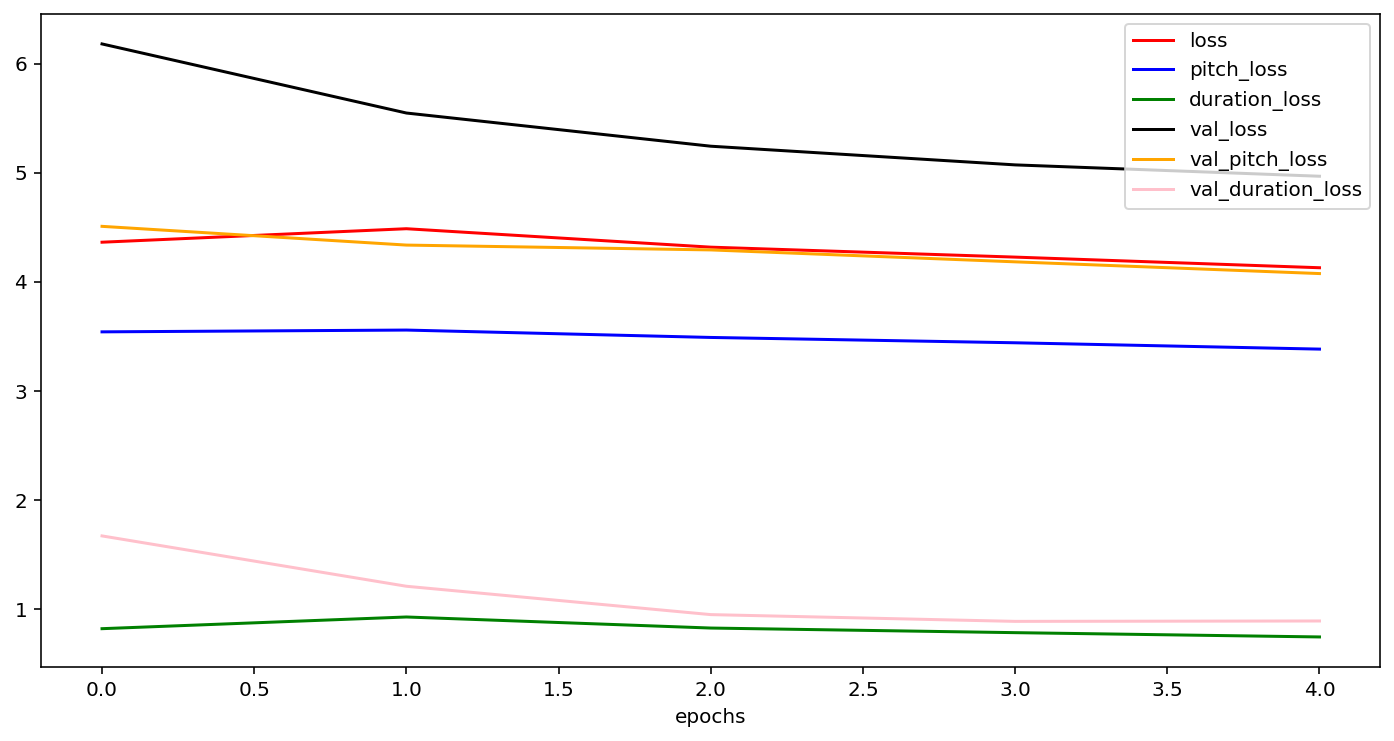

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

LSTMMusic.plot_history(
    [
        lstm_music.losses, lstm_music.n_losses, lstm_music.d_losses,
        lstm_music.val_losses, lstm_music.val_n_losses, lstm_music.val_d_losses
    ],
    [
        'loss', 'pitch_loss', 'duration_loss', 'val_loss', 'val_pitch_loss', 'val_duration_loss' 
    ]
)

In [21]:
lstm_music2 = LSTMMusic.load(save_path)
print(lstm_music2.epochs)

5


In [22]:
h=lstm_music2.train(
        (train_x_notes, train_x_durations), 
        (train_y_notes_ohv, train_y_durations_ohv),
        epochs=10,
        batch_size=32,
        run_folder = save_path,
        print_step_interval=1000,
        validation_data = ((val_x_notes, val_x_durations), (val_y_notes_ohv, val_y_durations_ohv))
)

6/10 loss 4.278 pitch_loss 3.496 duration_loss 0.782 val_loss 4.873 val_pitch_loss 3.975 val_duration_loss 0.898 0:00:11.048121
7/10 loss 4.089 pitch_loss 3.376 duration_loss 0.713 val_loss 4.705 val_pitch_loss 3.898 val_duration_loss 0.807 0:00:25.836999
8/10 loss 3.983 pitch_loss 3.316 duration_loss 0.667 val_loss 4.600 val_pitch_loss 3.832 val_duration_loss 0.768 0:00:41.062060
9/10 loss 3.973 pitch_loss 3.308 duration_loss 0.665 val_loss 4.449 val_pitch_loss 3.697 val_duration_loss 0.752 0:00:49.064355
10/10 loss 3.887 pitch_loss 3.253 duration_loss 0.635 val_loss 4.450 val_pitch_loss 3.702 val_duration_loss 0.748 0:00:57.467114


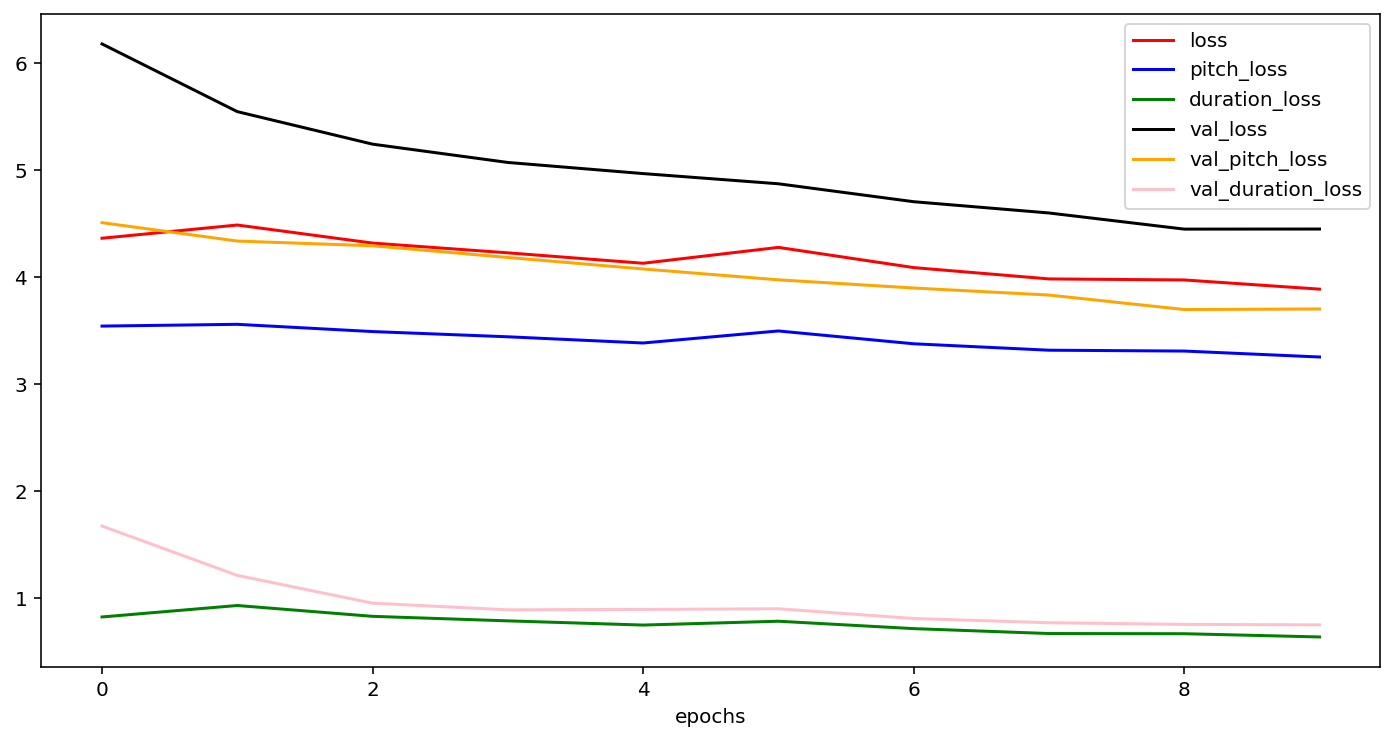

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

LSTMMusic.plot_history(
    [
        lstm_music2.losses, lstm_music2.n_losses, lstm_music2.d_losses,
        lstm_music2.val_losses, lstm_music2.val_n_losses, lstm_music2.val_d_losses
    ],
    [
        'loss', 'pitch_loss', 'duration_loss', 
        'val_loss', 'val_pitch_loss', 'val_duration_loss' 
    ]
)